In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


### 1. Read in the data

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

diabetes_df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 2. Explore and vizualize the data

In [4]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
diabetes_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
diabetes_df.duplicated().sum()

0

- There are many columns that contain various 0 values; these are likely Na values and should be replaced
- Pregnancies and Outcome with values of zero should be kept

In [8]:
replace_cols = [col for col in diabetes_df.columns if not(col == 'Outcome' or col == 'Pregnancies')]

diabetes_df[replace_cols] = diabetes_df[replace_cols].replace({0: np.nan})

diabetes_df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [9]:
# create a version of the df with no NaN for testing use (**not to be used for real training**)
# just used to test pipeline functions on some non NaN data
testing_df = diabetes_df.dropna()
testing_y = testing_df.pop('Outcome')
testing_df.isna().sum()
testing_y

3      0
4      1
6      1
8      1
13     1
      ..
753    1
755    1
760    0
763    0
765    0
Name: Outcome, Length: 392, dtype: int64

- Split up the data in order to avoid leakage
- Only use df_train and y_train for training the model
- The testing data should not be looked at so it will be left aside until the final model is created (to test the final model)

In [10]:
from sklearn.model_selection import train_test_split
y_outcome = diabetes_df.pop('Outcome')
df_train, df_test, y_train, y_test = train_test_split(diabetes_df, y_outcome, test_size=0.2, stratify=y_outcome, random_state=8)

<AxesSubplot:>

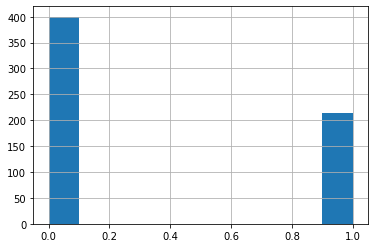

In [11]:
y_train.hist()

- Evident from the graph, the training data contains more non diabetics than diabetics

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>, <AxesSubplot:>]],
      dtype=object)

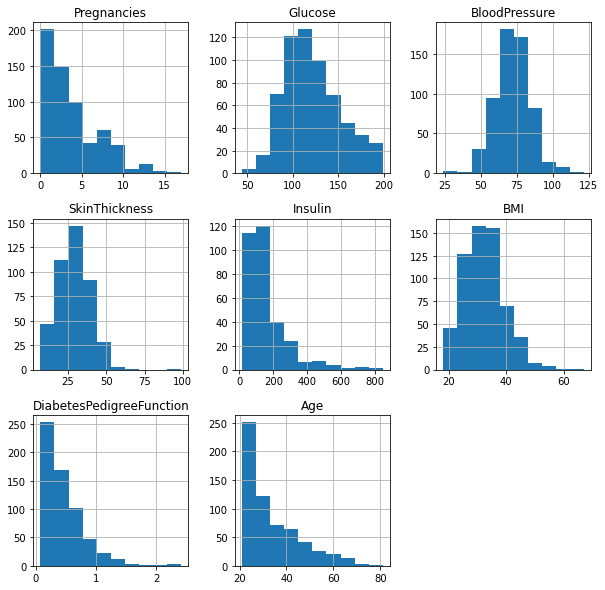

In [12]:
df_train.hist(figsize=(10, 10))

- Factors that are commonly known to be associated with diabetes occur in adults who have type 2 diabetes
- Type 1 diabetes may occur in kids and the causes are still unknown
- Adults with a certain combinations of factors (like obesity or family history) are more likely to develop T2D
- Family history also affects T1D
- The diabetes pedigree function takes family history into account

In [13]:
import seaborn as sns
from typing import Tuple
def kde_with_log(x: str, df: pd.DataFrame = df_train) -> Tuple[sns.kdeplot]:
    """Make a kde graph with the logged version of the graph beside
    """
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    ax1 = sns.kdeplot(data=df_train, x=x, ax=axs[0])
    ax1.set_title(f'{x} Frequency')

    if df_train[x].min() != 0:
        # apply normal log if no values are less than 0
        log_x = df_train[x].apply(np.log)
    else:
        # apply shifted log if some values equal zero
        log_x = df_train[x].apply(np.log1p)
    ax2 = sns.kdeplot(x=log_x, ax=axs[1])
    ax2.set_title(f'Logged {x} Frequency')
    
    return (ax1, ax2)

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

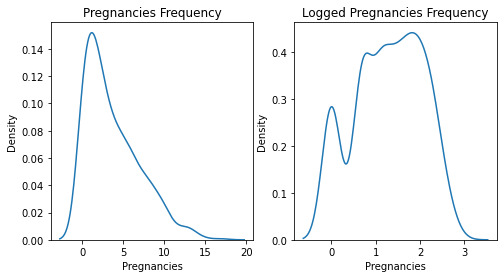

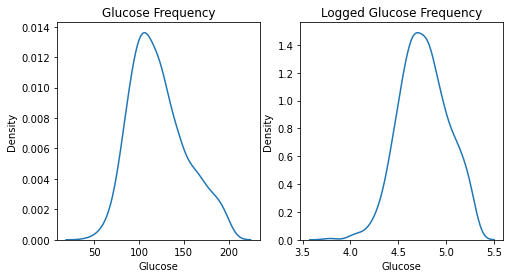

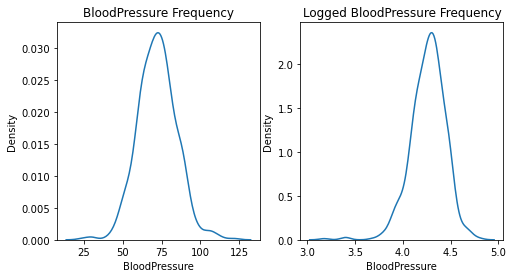

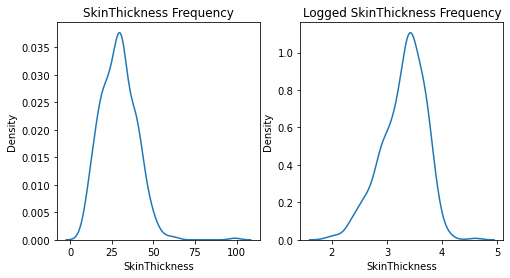

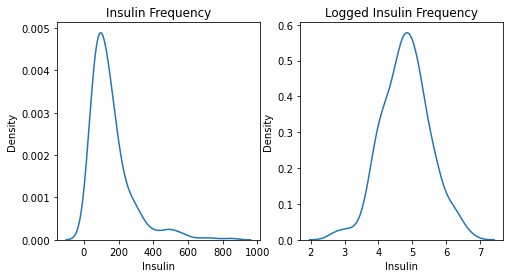

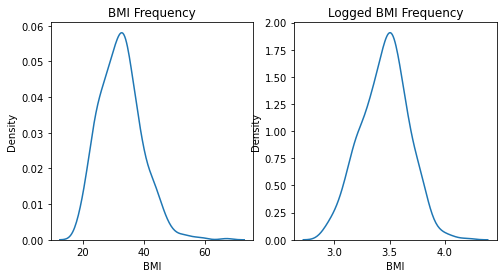

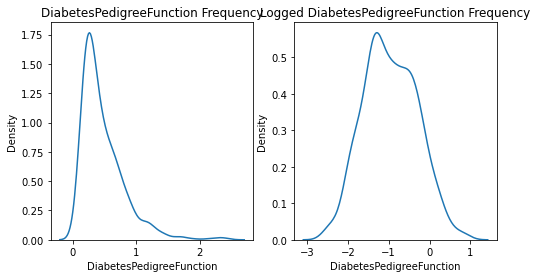

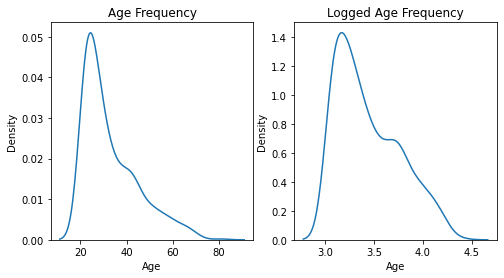

In [15]:
# check all logged relationships to see which right skewed distributions may be more informative with a log transformation
for col in df_train.columns:
    ax1, ax2 = kde_with_log(col)

In [16]:
def numerical_v_outcome(x, y, ax, graph_type='violin', title=None, df=df_train):
    if title == None:
        title = f'{y} vs Outcome'
    if type(y) == str:
        sns_y = df[y]
    else:
        sns_y = y
        
    if graph_type == "violin":
        ax = sns.violinplot(x=x, y=sns_y, ax=ax)
    else:
        ax = sns.boxplot(x=x, y=sns_y, ax=ax)
    ax.set_title(title)
    return ax

<AxesSubplot:title={'center':'Log DiabetesPedigreeFunction vs Outcome Boxplot'}, xlabel='Outcome', ylabel='DiabetesPedigreeFunction'>

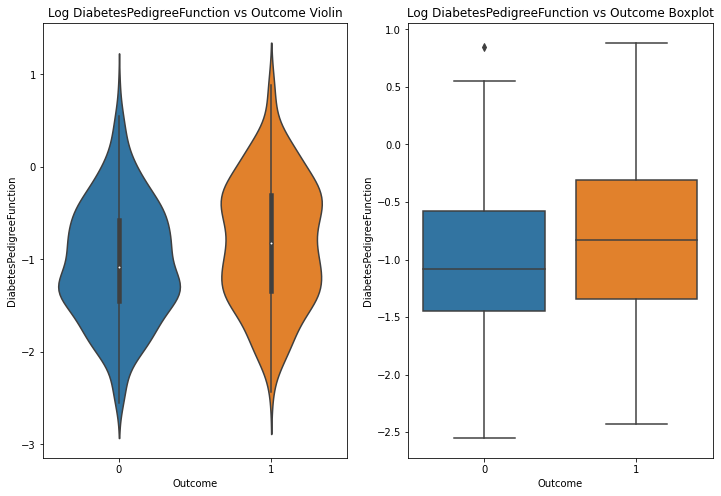

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
numerical_v_outcome(y_train, df_train['DiabetesPedigreeFunction'].apply(np.log), ax[0], title='Log DiabetesPedigreeFunction vs Outcome Violin')
numerical_v_outcome(y_train, df_train['DiabetesPedigreeFunction'].apply(np.log), ax[1], graph_type='boxplot', title='Log DiabetesPedigreeFunction vs Outcome Boxplot')

<AxesSubplot:title={'center':'Log Age vs Outcome Boxplot'}, xlabel='Outcome', ylabel='Age'>

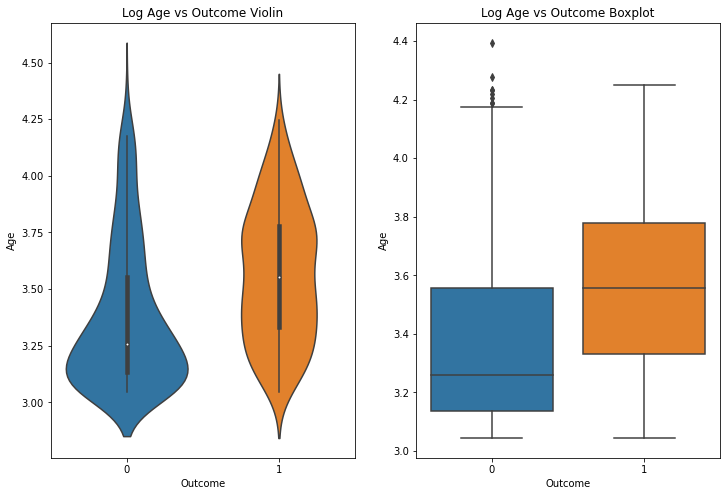

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
numerical_v_outcome(y_train, df_train['Age'].apply(np.log), ax[0], title='Log Age vs Outcome Violin')
numerical_v_outcome(y_train, df_train['Age'].apply(np.log), ax[1], graph_type='boxplot', title='Log Age vs Outcome Boxplot')

<AxesSubplot:title={'center':'Log Pregnancies vs Outcome Boxplot'}, xlabel='Outcome', ylabel='Pregnancies'>

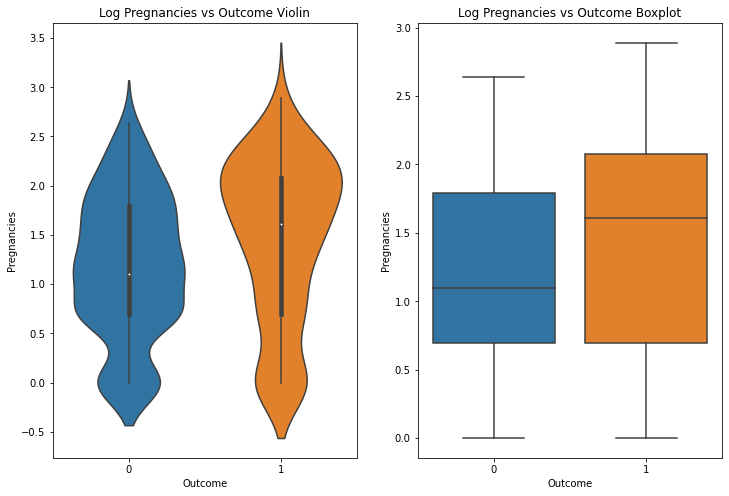

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
numerical_v_outcome(y_train, df_train['Pregnancies'].apply(np.log1p), ax[0], title='Log Pregnancies vs Outcome Violin')
numerical_v_outcome(y_train, df_train['Pregnancies'].apply(np.log1p), ax[1], graph_type='boxplot', title='Log Pregnancies vs Outcome Boxplot')

<AxesSubplot:title={'center':'Log Insulin vs Outcome Boxplot'}, xlabel='Outcome', ylabel='Insulin'>

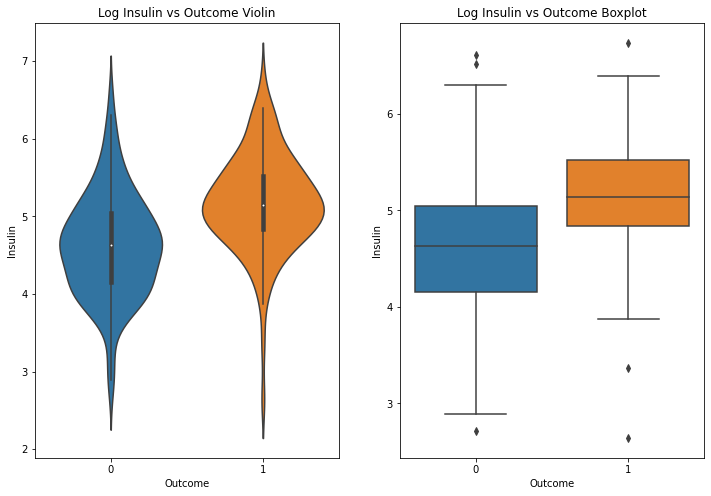

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
numerical_v_outcome(y_train, df_train['Insulin'].apply(np.log), ax[0], title='Log Insulin vs Outcome Violin')
numerical_v_outcome(y_train, df_train['Insulin'].apply(np.log), ax[1], graph_type='boxplot', title='Log Insulin vs Outcome Boxplot')

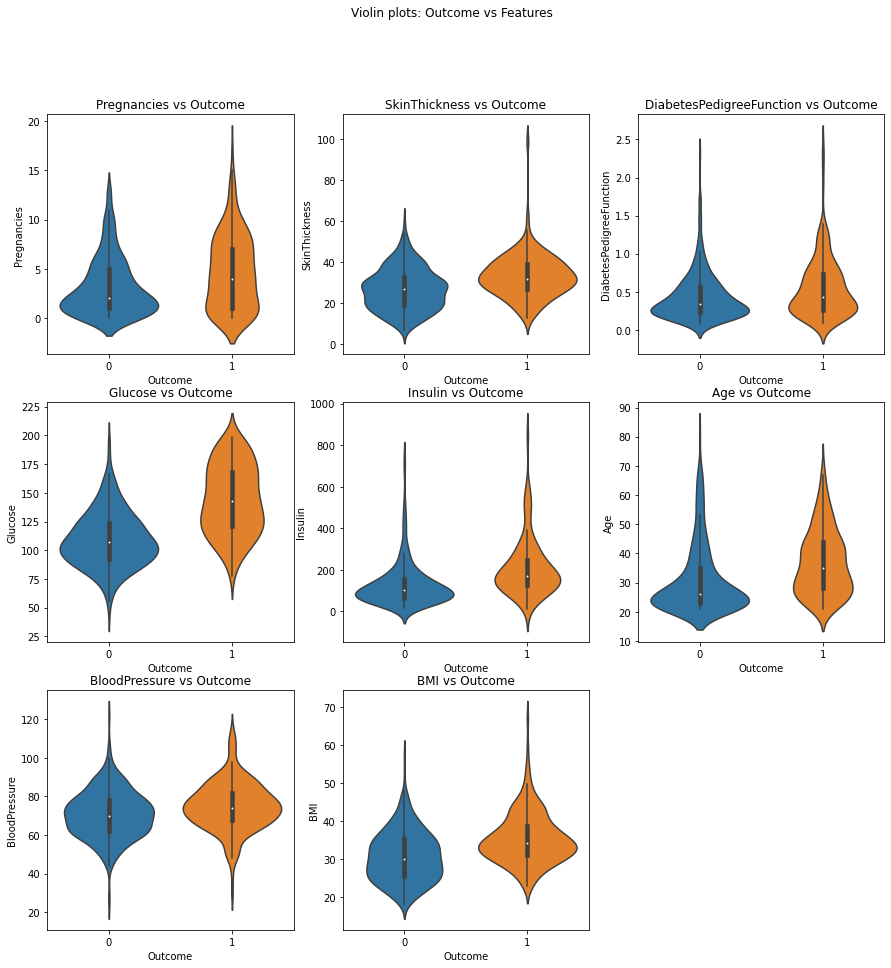

In [21]:
# plot various factors vs the outcome with a violin plot to see the frequency of distribution
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
index_1 = 0
index_2 = 0
fig.suptitle('Violin plots: Outcome vs Features')

for i in range(len(df_train.columns)):
#     if diabetes_df.columns[i] != "Outcome":
    numerical_v_outcome(y_train, df_train.columns[i], axes[index_1, index_2])
#     else:
#         fig.delaxes(axes[index_1, index_2])
    index_1 += 1
    if index_1 == 3:
        index_1 = 0
        index_2 += 1
fig.delaxes(axes[index_1, index_2])

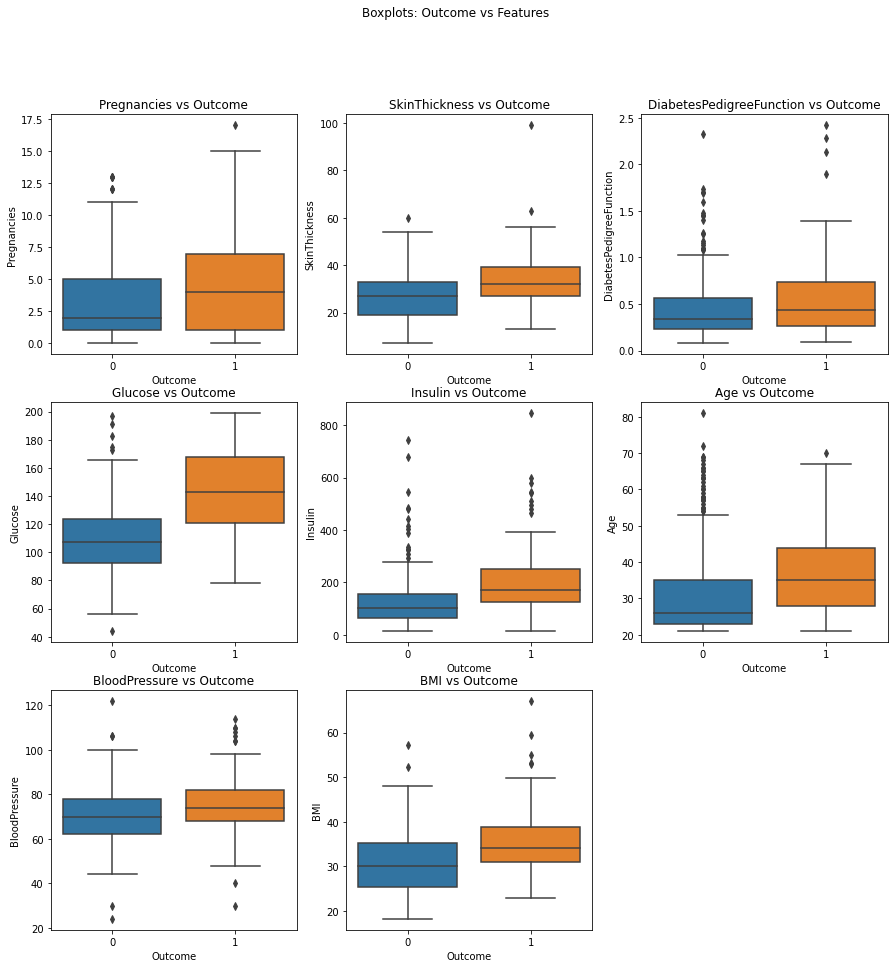

In [22]:
# plot various factors vs the outcome showing the points to spot outliers
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
index_1 = 0
index_2 = 0
fig.suptitle('Boxplots: Outcome vs Features')

for i in range(len(df_train.columns)):
#     if diabetes_df.columns[i] != "Outcome":
    numerical_v_outcome(y_train, df_train.columns[i], axes[index_1, index_2], graph_type='boxplot')
#     else:
#         fig.delaxes(axes[index_1, index_2])
    index_1 += 1
    if index_1 == 3:
        index_1 = 0
        index_2 += 1
fig.delaxes(axes[index_1, index_2])

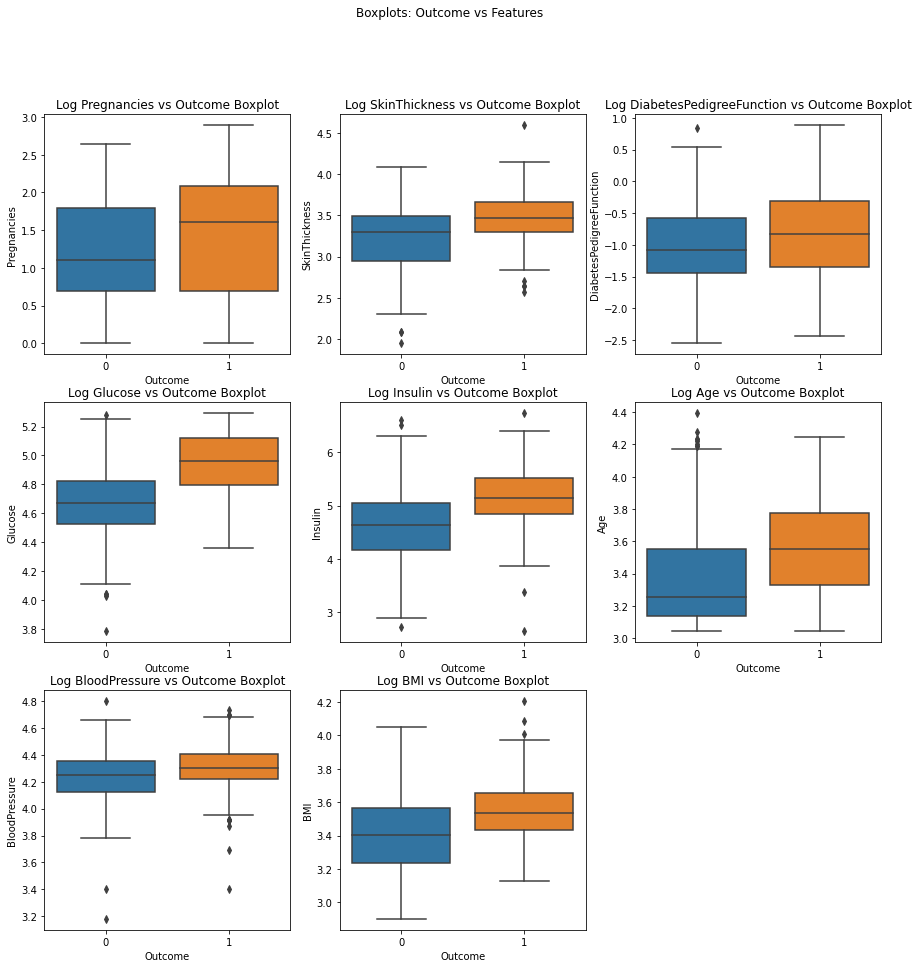

In [23]:
# plot various logged factors vs the outcome to show how normalizinf the data works
# note, some of these graphs are repeated from the large graphs before
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
index_1 = 0
index_2 = 0
fig.suptitle('Boxplots: Outcome vs Features')

for i in range(len(df_train.columns)):
    if df_train[df_train.columns[i]].min() > 0:
        numerical_v_outcome(y_train, df_train[df_train.columns[i]].apply(np.log), axes[index_1, index_2], graph_type='boxplot', title=f'Log {df_train.columns[i]} vs Outcome Boxplot')
    else:
        numerical_v_outcome(y_train, df_train[df_train.columns[i]].apply(np.log1p), axes[index_1, index_2], graph_type='boxplot', title=f'Log {df_train.columns[i]} vs Outcome Boxplot')
    index_1 += 1
    if index_1 == 3:
        index_1 = 0
        index_2 += 1
fig.delaxes(axes[index_1, index_2])

- By comparing the graphs, it is evident that blood glucose, age, and BMI mark visible differences
- The diabetes pedigree function is surprisingly not as useful as I would have expected it to be
- 3 features seemed to be normalized better using a log transformation: consider replacing the features by the logged versions. The 3 features were: DiabetesPedigreeFunction, Insulin, and Age. The pregnency feature is also well normalized with a log transformation. 
- Many of the graphs also have outliers in the upper ranges so it would be good to scale those values into more normal ranges to not overfit the model

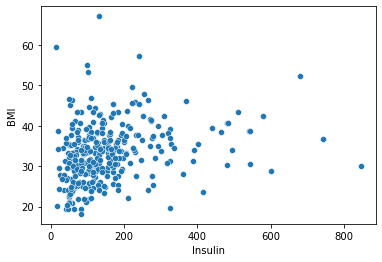

In [24]:
# explore insulin vs bmi
ax = sns.scatterplot(x=df_train['Insulin'], y=df_train['BMI'])

### 3. Basic model
- The data has NaN values and has not been split up
- Create a basic pipeline which can deal with imputing and applies an XGBClassifier
- Use cross validation on the classifier to ensure accurate scores; call a scoring function with the initial train data and basic model to get a baseline score

In [25]:
from sklearn.base import TransformerMixin, BaseEstimator

class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        # store the attribute X_ to see scaled data in this step
        self.X_ = X
        return X
        
    def fit(self, X, y=None, **fit_params):
        return self

In [26]:
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.impute import SimpleImputer

basic_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('clean_data', Debug()),
    ('model', xgb.XGBClassifier(random_state=0, verbosity=0))
])

basic_pipeline_data = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('clean_data', Debug())
])

basic_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('clean_data', Debug()),
                ('model',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=0, reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
           

In [27]:
def get_median_imputed_data(df):
    median_imputer = SimpleImputer(strategy='median')
    imputed_df = pd.DataFrame(median_imputer.fit_transform(df), columns=df.columns)
    return imputed_df

In [28]:
# impute median values separately to avoid leakage
# imputed_df_train = pd.DataFrame(median_imputer.fit_transform(df_train))
# imputed_df_test = pd.DataFrame(median_imputer.transform(df_test))

# imputed_df_train.columns = df_train.columns
# imputed_df_test.columns = df_test.columns

# # confirm no NaN values
# imputed_df_train.isna().sum()

### 4. Baseline Scoring
- With data now being clean, make a function which can score a model based on particular data
- Call this function with the initial train data and basic model to get a baseline score

In [29]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score


def score_pipeline_model(X, y, pipeline, scoring):
    """
    Score a model that is in a pipeline
    """
    scores = cross_val_score(pipeline, X, y, scoring=scoring)
    return scores.mean()

In [30]:
mean_accuracy = score_pipeline_model(df_train, y_train, basic_pipeline, 'accuracy')
print(mean_accuracy)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder i

0.757323737171798


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [31]:

# from sklearn.metrics import classification_report, roc_auc_score
# def score_model(X, y, model=xgb.XGBClassifier(random_state=0)):
#     """
#     Score a model assuming data has already been preprocessed
#     """
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
#     clf = model.fit(X_train, y_train)
#     pred = clf.predict(X_test)
#     return classification_report(y_test, pred)

- Initial model has accuracy of about 76%
- Use feature engineering to improve the performance

### 4. Feature Engineering
- Apply feature engineering (to just training data for the initial testing but whole data set on full run)
- Apply Kmeans for grouping in clusters as well as distance to a certain cluster
- Apply PCA to explore loadings of Principal Components (PC)
- Given loadings of PC, apply mathematical transformations and interactions between data (ratios, sums, diff, etc)
- Consider applying log transformations to certain skewed features
- Make counts (XGB is a tree based model which cannot aggregate well across multiple columns). Do counts for above and below the respective medians
- Flag or move outliers into the interquartile range (IQR). Some data outside of this range my not be outliers - do not just remove extreme data.
- Create bins for numerical columns to avoid over fitting
- Make sure all transformations are in functions (so that function transformers can be applied to the pipeline)
- Make a pipeline containing the transformations and try out different combinations to see what gives the best results

In [32]:
from typing import List
def _set_up_kmeans(df: pd.DataFrame, features: List[int]) -> pd.DataFrame:
    """Private function to normalize data for kmeans
    
    Args:
        df: Current dataframe being used
        features: List of features for kmeans to be applied on
    
    Returns:
        Dataframe for specific features with scaled data
    """
    df_copy = df.copy()
    df_selected = df_copy[features]
    df_scaled = (df_selected - df_selected.mean(axis=0)) / df_selected.std(axis=0)
    return df_scaled
    

In [33]:
from sklearn.cluster import KMeans

def kmeans_cluster(df: pd.DataFrame, n_clusters: int) -> pd.DataFrame:
    """Creates cluster features using Kmeans on certain features
    
    Args:
        df: Current dataframe being used
        n_clusters: The number of clusters to create using Kmeans
        
    Returns:
        The same dataframe with an additional clusters feature
    """
    features = ['BMI', 'Insulin', 'Glucose', 'Age', 'Pregnancies']
    X_scaled = _set_up_kmeans(df, features)
  
    k_means = KMeans(n_clusters, n_init=50, max_iter=1000, random_state=42)
    
    # make a new column in the dataframe for each cluster
    df['Cluster'] = k_means.fit_predict(X_scaled)
    return df  

In [34]:
def kmeans_cluster_dist(df: pd.DataFrame, n_clusters: int) -> pd.DataFrame:
    """Creates cluster distance features for kmeans on certain df features
    
    Args:
        df: Current dataframe being used
        n_clusters: The number of clusters to create using Kmeans
        
    Returns:
        The same dataframe with an additional cluster distances features
    """
    features = ['BMI', 'Insulin', 'Glucose', 'Age', 'Pregnancies']
    X_scaled = _set_up_kmeans(df, features)
    
    k_means = KMeans(n_clusters, n_init=50, max_iter=1000, random_state=41)
    cluster_distances = k_means.fit_transform(X_scaled)
    
    # make a new df for the cluster distances and join it to the old df
    cluster_dist_df = pd.DataFrame(cluster_distances, columns=[f'centeroid_dist_{i}' for i in range(cluster_distances.shape[1])], index=df.index)
#     print(cluster_dist_df)
    df = df.join(cluster_dist_df)
    return df

- Make a function to calculate MI scores
- Test on some data and use it on PCA to check usefulness of principal components (PCs)

In [35]:
from sklearn.feature_selection import mutual_info_regression
def get_mi_scores(df, y):
    df = df.copy()
    # label encode categorical data
    for col in df.select_dtypes(['object', 'category']):
        df_copy[col], _ = df[col].factorize()
    discrete = [pd.api.types.is_integer_dtype(col_type) for col_type in df.dtypes]
    mi_scores = pd.Series(mutual_info_regression(df, y, discrete_features=discrete, random_state=42), index=df.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [36]:
# test mutual index with the non zero features
print(get_mi_scores(testing_df, testing_y))

Glucose                     0.165975
Insulin                     0.084278
Age                         0.080055
Pregnancies                 0.078489
BMI                         0.061932
BloodPressure               0.030414
SkinThickness               0.002946
DiabetesPedigreeFunction    0.000000
dtype: float64


- The featues between glucose and BMI seem to have the most effect. This is seen in the EDA and in the mi scores for the data
- Use these 5 features for PCA and Kmeans

In [37]:
from sklearn.decomposition import PCA
from typing import Tuple
def _apply_pca(df: pd.DataFrame, features: List[str]) -> Tuple[np.ndarray, PCA, List[str]]:
    """Private funciton to apply pca on certain features in a df
    
    Args:
        df: Current dataframe being used
        features: List of features for pca to be applied on
    
    Returns:
        Numpy array containing the principal components for specific features, trained PCA model, and column names for the PCs
    """
    df = df[features].copy()
    df = (df - df.mean(axis=0)) / df.std(axis=0)
    # create architecture
    pca = PCA(random_state=42)
    pc = pca.fit_transform(df)
    
    # get column names
    new_cols = [f'pc_{i+1}' for i in range(len(features))]
    return (pc, pca, new_cols)

In [38]:
def create_pc_pca(df: pd.DataFrame, test: bool = True) -> pd.DataFrame:
    """Creates principal components after PCA is applied
    
    Args:
        df: The current dataframe being used
        test: If this is testing mode
    
    Returns:
        A new dataframe that contains the relevant principal components as features
    """
    
    if test:
        pc_y = testing_y
    else:
        pc_y = y_outcome
    df = df.copy()
    features = ['BMI', 'Insulin', 'Glucose', 'Age', 'Pregnancies']
    pc, pca, new_cols = _apply_pca(df, features)
    pc_df = pd.DataFrame(pc, columns=new_cols, index=df.index)
    
    # only take good PC 
    scores_array = get_mi_scores(pc_df, pc_y)
    evr = pca.explained_variance_ratio_
    
    good_pc = []
    MI_CUTOFF = 0.06
    EVR_CUTOFF = 1 / len(features)
    for i in range(len(features)):
#         print(scores_array[i], evr[i])
        if scores_array[i] > MI_CUTOFF and evr[i] > EVR_CUTOFF:
            good_pc.append(f'pc_{i+1}')
    
    pc_df = pc_df[good_pc]
    df = df.join(pc_df)
    return df
     

In [39]:
print(create_pc_pca(testing_df))

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
3              1     89.0           66.0           23.0     94.0  28.1   
4              0    137.0           40.0           35.0    168.0  43.1   
6              3     78.0           50.0           32.0     88.0  31.0   
8              2    197.0           70.0           45.0    543.0  30.5   
13             1    189.0           60.0           23.0    846.0  30.1   
..           ...      ...            ...            ...      ...   ...   
753            0    181.0           88.0           44.0    510.0  43.3   
755            1    128.0           88.0           39.0    110.0  36.5   
760            2     88.0           58.0           26.0     16.0  28.4   
763           10    101.0           76.0           48.0    180.0  32.9   
765            5    121.0           72.0           23.0    112.0  26.2   

     DiabetesPedigreeFunction   Age      pc_1      pc_2  
3                       0.167  21.0 -1.786374 -0.1121

In [40]:
# get an imputed version of the training data to check findings of PCA loadings
imputed_train_df = get_median_imputed_data(df_train)
imputed_train_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

In [41]:
def get_pca_loadings(df: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    df = df.copy()
    _, pca, col_names = _apply_pca(df, features)
    # get the loadings for the principal components
    loadings = pd.DataFrame(pca.components_.T, columns=col_names, index=features)
    return loadings

In [42]:
features = ['BMI', 'Insulin', 'Glucose', 'Age', 'Pregnancies']
# get the loadings for the principal components
loadings = get_pca_loadings(imputed_train_df, features)
loadings

,pc_1,pc_2,pc_3,pc_4,pc_5
BMI,0.269840,0.466645,-0.832013,0.098174,0.086865
Insulin,0.416074,0.454882,0.476668,0.611144,0.138765
Glucose,0.545500,0.280816,0.218072,-0.669181,-0.358070
Age,0.517210,-0.449468,-0.028627,-0.156624,0.710719
Pregnancies,0.434734,-0.542629,-0.179353,0.380171,-0.582978


- PC 1 shows that there are people who have high insulin, glucose, age, and pregnancies. These can be added to make a new 'vulnerable' category
- PC 3 shows a potential grouping of low bmi and high insulin (ratio can be made)

In [43]:
# repeat the same process using only 4 features to see if there are any different results
features_2 = ['BMI', 'Insulin', 'Glucose', 'Age']
loadings_2 = get_pca_loadings(imputed_train_df, features_2)
loadings_2

,pc_1,pc_2,pc_3,pc_4
BMI,0.400959,-0.591269,-0.682458,0.154545
Insulin,0.558068,-0.187669,0.610447,0.529807
Glucose,0.633900,0.103946,0.110637,-0.758370
Age,0.354913,0.777416,-0.386478,0.346836


- PC 2 in the above loadings show a contrast between age and bmi: low bmi and high age (may be expressed as a ratio)
- PC 4 in the above loadings and PC 3 in the below loadings show a contrast between glucose and insulin: low glucose and high insulin

In [44]:
# repeat one last time, this time without BMI
features_3 = ['Pregnancies', 'Insulin', 'Glucose', 'Age']
loadings_3 = get_pca_loadings(imputed_train_df, features_3)
loadings_3

,pc_1,pc_2,pc_3,pc_4
Pregnancies,0.506819,-0.507822,0.353195,-0.600421
Insulin,0.370485,0.647236,0.649674,0.147480
Glucose,0.514967,0.440914,-0.658956,-0.325854
Age,0.583681,-0.358884,-0.137677,0.715237


In [45]:
def pca_loading_features(df: pd.DataFrame, ignore_features: List[str] = []) -> pd.DataFrame:
    """Create new features from the above analysis of PCA loadings
    
    Args:
        df: The current DataFrame being used
        ignore_feature: List of features to ignore from the function
        
    Returns:
        A DataFrame with the new pca features
    """
    df = df.copy()
    if 'glucose_and_age' not in ignore_features:
        df['glucose_and_age'] = df['Glucose'] * df['Age']
    
    if 'insulin_to_bmi' not in ignore_features:
        df['insulin_to_bmi'] = df['Insulin'] / df['BMI']
    
    if 'age_to_bmi' not in ignore_features:
        df['age_to_bmi'] = df['Age'] / df['BMI']
    
    if 'insulin_glucose_effect' not in ignore_features:
        df['insulin_glucose_effect'] = df['Insulin'] / df['Glucose']
    
    return df

In [46]:
def unskew_with_log(df: pd.DataFrame) -> pd.DataFrame:
    """Apply log transformations to normalize data discovered in EDA
    
    Args:
        df: The current dataframe
    
    Returns:
        A new df containing logged versions of certain features
    """
    df=df.copy()
    
    features=['DiabetesPedigreeFunction', 'Insulin', 'Age', 'Pregnancies']
    
    # loop through list of features and apply log transformations
    for feature in features:
        if df[feature].min() > 0:
            df[f'logged_{feature}'] = df[feature].apply(np.log)
        else:
            df[f'logged_{feature}'] = df[feature].apply(np.log1p)
    return df

In [67]:
def compare_median(row: pd.Series, medians: pd.Series) -> pd.Series:
    """Adds counts to above or below medians
    
    Args:
        row: A row in a dataframe (one person)
        medians: The medians for the current dataframe
    
    Returns:
        A new series containing the new count features
    """
    # get counts for features above the median
    row['greater_than_median'] = row.gt(medians).sum()
    # get counts for features equal to or less than - remove to not have repetitive features
#     row['less_than_median'] = row.le(medians).sum()
    return row

In [68]:
def row_median_counts(df: pd.DataFrame) -> pd.DataFrame:
    """Apply counts above and below the median for each feature in a row
    
    Each of the initial features are higher in diabetics (seen in eda), so doing a median count on per feature will reveal more at risk people
    
    Args:
        df: The current dataframe
    
    Returns:
        A new df containing a median count feature
    """
    initial_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
    
    df = df.copy()
    medians = df[initial_cols].apply(lambda col: col.median())
    df = df.apply(compare_median, axis=1, args=(medians,))
    return df

In [ ]:
def remove_outliers():
    """Remove outliers from certain features to avoid over fitting
    
    """

### Hyperparameter tuning
- Use the best features to create a final pipeline
- Split the data into train/test data 
- Apply hyperparameters on the train data
- Create a final model using the training data and best hyperparameters
- Use the validation data to test the final model; use classification report to see how the model did